# Draft of the pipeline to extract training data with openEO to train the catboost model to run the inference workflow
This workflow is tailored to the WEED Slovakia test case which is used in the alpha-1 release.<br>
<br> We start from the extracted reference points for Slovakia. The following steps are carried out:
  - access the WEED Google drive
  - loading the reference points into a Geopandas Dataframe and adding a unique GeoLocationID to each point plus the global grid20id for grouping reference points into their corresponding 20x20 km UTM grid.
  - create the job-database to feat the openEO MultiBackendJobManager tiled data
  - create the start_job function to apply on the tiled data. This includes preprocessing the S1/S2 data, calculating VI's and the final features PLUS adding addional features from non-EO sources (here only the WERN features and Copernicus 30 DEM) loaded from external STAC catalogs.
  - init of the openEO session and running the JobManager
  - checking the results of the openEO processing and adding the extracted features to the reference data
  - saving the training data to disk for catboost model training

In [19]:
from eo_processing.utils.storage import WEED_GDRIVE_Access, print_gdrive_overview, get_gdrive_gdf
from eo_processing.utils.helper import init_connection
from eo_processing.utils.jobmanager import WeedJobManager
from eo_processing.utils.geoprocessing import get_point_info
from eo_processing.utils.mgrs import gridID_2_epsg
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import geojson
import openeo
from openeo.extra.job_management import CsvJobDatabase
import platform

### getting access to the WEED Google Drive to retrieve the reference dataset for Slovakia

In [2]:
# init the GDRIVE access
gdrive = WEED_GDRIVE_Access(username='buchhornm', entry_point="1k27bitdRp41AtHq1xupyqwKaTLzrMUMu")

Please enter your password for the Terrascope VAULT:  ········


In [3]:
# get an overview of the folder structure
print_gdrive_overview(gdrive)

Found directory: 1k27bitdRp41AtHq1xupyqwKaTLzrMUMu
	European_terrestrial_LAEA20km_grid.gpkg
	global_terrestrial_UTM20k_grid.gpkg
	SK_v5_reference-points_EUNIS2012.csv
	global_terrestrial_UTM100k_grid.gpkg


### loading of the reference points CSV file as PANDAS dataframe
Note: since we load the dataset directly from the GDrive we have to construct the filename in a specific manner and then load it in Pandas as file-like object <br>
In a later state this step will be replaced with direct query of the RDM provided by IIASA.

In [4]:
# Load the CSV file into a pandas dataframe
path_td = gdrive.root + "/" + 'SK_v5_reference-points_EUNIS2012.csv'
with gdrive.open(path_td, 'rb') as f:
    df = pd.read_csv(f)

df.head()

,fid,entry,x,y,valid_L1,valid_L2,valid_L3,lon,lat,label_L1,label_L2,label_L3
0,1,P5000001,4.849642e+06,2.811280e+06,True,True,True,17.118680,48.185489,C,C3,C3.4
1,2,P5000002,4.851750e+06,2.815627e+06,True,True,True,17.152425,48.222568,C,C3,C3.4
2,3,P5000003,4.854840e+06,2.816960e+06,True,True,True,17.195542,48.231791,C,C3,C3.4
3,4,P5000004,4.854535e+06,2.819285e+06,True,True,True,17.194425,48.252869,C,C3,C3.4
4,5,P5000005,4.855180e+06,2.819730e+06,True,True,True,17.203641,48.256284,C,C3,C3.4


### adding 10m GeoLocation identifier & cell center coordinates plus additional columns/checks
It is crucial that the reference data is in EPSG:4326 - identify the correct columns OR warp coordinates of other EPSG to EPSG:4326.
The MGRSid10 is a unique GeoLocation identifier at 10m spatial resolution in the UTM grid - this allows that reference point labels can be assigned always to the correct EO/non-EO extracted features. The MGRSid10 has 13-digits and specify the lower left corner of the 10x10 m pixel in the MGRS notation. The center_lon/lat represents the center coordinate of the corresponding 10x10m pixel in the UTM grid (10m square covered by the MGRSid10). <br>
The grid20id shows in which 20x20km processing tile the corresponding reference point falls - that allows the pre-grouping of the reference points for efficient processing.

In [5]:
# first we add the unique MGRSid10 identifier and the corresponding center coordinates in EPSG:4326 for the 10m patch
df[['MGRSid10', 'center_lon', 'center_lat', 'grid20id']] = df.apply(lambda row: get_point_info(row['lon'], row['lat']), axis=1, result_type='expand')

In [6]:
# remove non-needed columns when exist
columns_to_remove = ['fid', 'entry', 'x', 'y']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

In [7]:
# Check and remove duplicate entries in the 'MGRSid10' column
if df['MGRSid10'].duplicated().any():
    duplicates = df[df['MGRSid10'].duplicated(keep=False)]
    print("Duplicate entries found in MGRSid10:")
    print(duplicates[['MGRSid10', 'lon', 'lat', 'center_lon', 'center_lat']])
    # Remove all entries with duplicate MGRSid10
    df = df[~df['MGRSid10'].duplicated(keep=False)]
    print("Duplicates have been removed.")
else:
    print("No duplicate entries in MGRSid10")

Duplicate entries found in MGRSid10:
            MGRSid10        lon        lat  center_lon  center_lat
324    34UCU58116788  19.081292  48.448086   19.081224   48.448101
325    34UCU58136787  19.081471  48.448019   19.081498   48.448016
326    34UCU58126789  19.081411  48.448215   19.081356   48.448193
327    34UCU58116784  19.081256  48.447704   19.081238   48.447741
328    34UCU58126789  19.081406  48.448226   19.081356   48.448193
...              ...        ...        ...         ...         ...
44731  33TXP78931371  17.396612  47.951694   17.396573   47.951731
44732  33TXP78941369  17.396760  47.951573   17.396699   47.951548
44733  33TXP78941369  17.396698  47.951554   17.396699   47.951548
44734  33TXP78891371  17.396035  47.951783   17.396038   47.951742
44735  33TXP78941369  17.396732  47.951563   17.396699   47.951548

[125 rows x 5 columns]
Duplicates have been removed.


In [8]:
# reorder the columns just for better reading
cols = df.columns.tolist()
new_order = ['MGRSid10', 'center_lon', 'center_lat', 'lon', 'lat', 'grid20id']
remaining_cols = [col for col in cols if col not in new_order]
df = df[new_order + remaining_cols]

df.head()

,MGRSid10,center_lon,center_lat,lon,lat,grid20id,valid_L1,valid_L2,valid_L3,label_L1,label_L2,label_L3
0,33UXP57473908,17.118710,48.185468,17.118680,48.185489,33σXP21,True,True,True,C,C3,C3.4
1,33UXP59864327,17.152421,48.222541,17.152425,48.222568,33σXP22,True,True,True,C,C3,C3.4
2,33UXP63034439,17.195500,48.231803,17.195542,48.231791,33σXP32,True,True,True,C,C3,C3.4
3,33UXP62884673,17.194382,48.252879,17.194425,48.252869,33σXP32,True,True,True,C,C3,C3.4
4,33UXP63564713,17.203691,48.256300,17.203641,48.256284,33σXP32,True,True,True,C,C3,C3.4


### convert the Pandas DataFrame into a GeoPandas DataFrame with center point geometry

In [9]:
geometry = [Point(xy) for xy in zip(df.center_lon, df.center_lat)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df = geo_df.set_crs('epsg:4326')
print(f'Number of reference points: {len(geo_df)}')

Number of reference points: 45124


<Axes: >

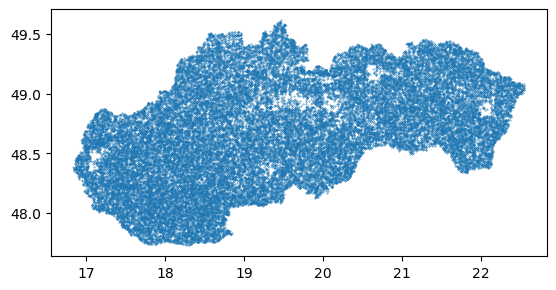

In [10]:
# just visualize for checks
geo_df.geometry.plot(markersize=0.1)

### split the geodataframe by 20kgrid into stand-alone dataframes for job operation
the 20kgrid represent the best size for working in openEO and is also needed to avoid openEO limitations for extraction. We use the grid20id for the grouping.


In [11]:
split_jobs = [geo_df[geo_df['grid20id'] == tile_id] for tile_id in geo_df['grid20id'].unique()]
print(f'Number of jobs: {len(split_jobs)}')

Number of jobs: 170


<Axes: >

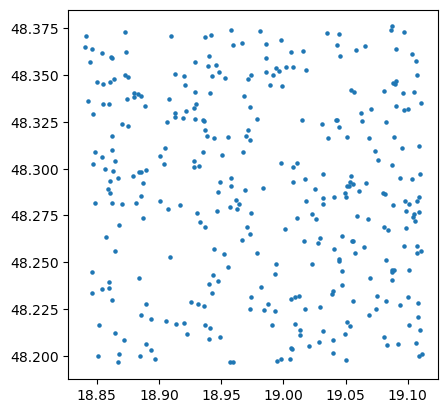

In [12]:
# for visualization we print all the points of one of the 20x20 km tiles (openEO processing tiles identified by grid20id)
split_jobs[100].geometry.plot(markersize=5)

### create the job dataframe with all info to run the openEO `MultiBackendJobManager` for the data extraction
For each job which has to run on openEO we need an extra row in a `pandas.DataFrame` (or `geopandas.DataFrame`) which is handling all information needed by the JobManager to execute the `start_function`. The output dataframe should be savable as a .csv file. <br> <br>
Note: the full information of a sub-geodataframe of points/polygons can be saved into a row of a `pandas.DataFrame` by storing it in a row as string implementing the `geojson.FeatureCollection` interface. To convert the `geopandas.GeoDataFrame` into a string, simply use the `.to_json()` function.
<br><br> Note: make sure you have a row specific column called "name" in case you want run visualization.


In [13]:
def create_job_dataframe(split_jobs: list[gpd.GeoDataFrame], year: int, file_name_base: str) -> pd.DataFrame:
    """ Create a dataframe from the pre-split GeoDataFrame, containing all the necessary information to run the job.
    
    :param split_jobs: List of GeoDataFrames, each containing job information such as S2 tile ID and geometries.
    :param year: Year for which to create job entries. The start date will be January 1st of this year, and the end date will be January 1st of the following year.
    :param file_name_base: Base file name to be used, with the S2 tile ID appended to create unique file names for each job.
    :return: DataFrame containing job information, including the S2 tile ID, generated file name, start date, end date, and geometry as a JSON object.
    """
    
    columns = ['name', 'target_epsg', 'file_prefix', 'start_date', 'end_date', 'FeatureCollection']
    dtypes = {'name': 'string', 'target_epsg': 'UInt16', 'file_prefix': 'string', 'start_date': 'string', 'end_date': 'string', 'FeatureCollection': object}
    rows = []
    for job in split_jobs:
        # set master parameters
        start_date = f'{year}-01-01'
        end_date = f'{year+1}-01-01'
        grid20id = job.grid20id.iloc[0]  # Job dataframes are split depending on the grid20id so we can just take the first one
        epsg = gridID_2_epsg(grid20id)
        file_prefix = f'{file_name_base}_{grid20id}'
        
        rows.append(
            pd.Series(
                dict(zip(columns, [grid20id, epsg, file_prefix, start_date, end_date, job[['MGRSid10', 'geometry']].to_json()])),
            )
        )

    return pd.DataFrame(rows).astype(dtypes)

In [14]:
job_df = create_job_dataframe(split_jobs, 2021, 'TD_SK-v5_EUNIS2012')

In [15]:
# add the number of points to handle in each 20x20km grid cell
def get_point_number(row: pd.Series) -> int:
    """
    :param row: A pandas Series object that contains a geometry field with a GeoJSON string.
    :return: The number of features present in the GeoJSON geometry.
    """
    return len(geojson.loads(row.FeatureCollection)['features'])

job_df['n_points'] = job_df.apply(get_point_number, axis=1)

In [16]:
# for Job status visualization of the training data extraction, we have to add a geometry to each row and convert the Pandas into a GeoPandas DataFrame
# that is the huge difference to inference which is running directly on 20x20km tiles which give the geometry
# Note: we use the grid20id polygon of the global UTM tiling grid for that
path_global_grid = gdrive.root + "/" + 'global_terrestrial_UTM20k_grid.gpkg'

# since the GeoPackage is huge we use a helper function
gdf_grid = get_gdrive_gdf(gdrive, path_global_grid, filter_bbox=tuple(geo_df.total_bounds))

# merge in the needed Polygons and convert to GeoDataFrame
job_df = pd.merge(job_df, gdf_grid[['grid20id', 'geometry']], left_on='name', right_on='grid20id', how='left')
job_df = gpd.GeoDataFrame(job_df, geometry='geometry')

In [17]:
job_df.head()

,name,target_epsg,file_prefix,start_date,end_date,FeatureCollection,n_points,grid20id,geometry
0,33σXP21,32633,TD_SK-v5_EUNIS2012_33σXP21,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",118,33σXP21,"POLYGON ((17.153 48.193, 17.146 48.013, 16.877..."
1,33σXP22,32633,TD_SK-v5_EUNIS2012_33σXP22,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",323,33σXP22,"POLYGON ((17.161 48.373, 17.153 48.193, 16.884..."
2,33σXP32,32633,TD_SK-v5_EUNIS2012_33σXP32,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",424,33σXP32,"POLYGON ((17.43 48.367, 17.422 48.188, 17.153 ..."
3,33σXP33,32633,TD_SK-v5_EUNIS2012_33σXP33,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",375,33σXP33,"POLYGON ((17.439 48.547, 17.43 48.367, 17.161 ..."
4,33σXQ30,32633,TD_SK-v5_EUNIS2012_33σXQ30,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",235,33σXQ30,"POLYGON ((17.456 48.907, 17.448 48.727, 17.176..."


### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_. <br> <br>
Note: for the training data extraction we first have to generate the S1/S2 features and then adding the DEM and WERN non-Eo features via a merge. Important: for point extraction we do not define a spatial_extent in the collection at all AND run an aggregation_spatial with the GeoJSON FeatureCollection which will hand over the maxium extent internally. For patch extraction, we do not define a spatial_extent in the collection at all and later run a cube.filter_spatial(GeoJSON).

In [18]:
def point_extraction(row: pd.Series, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs DataFrame and connection."""
    
    # Get the variable parameters from the dataframe
    gridID = row["grid20id"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_prefix"]
    epsg = int(row["target_epsg"])
    
    #now we have to load the point geometries for all the points to process
    points_geometry = geojson.loads(row.FeatureCollection)
    assert isinstance(points_geometry, geojson.FeatureCollection)

    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider)
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')

    # adapt the epsg to the grid20id
    processing_options.update(target_crs = epsg)

    # define the S1/S2 processed feature cube (Note: do not set spatial extent)
    data_cube = generate_master_feature_cube(connection,
                                             None,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)

    # now we merge in the NON ON-DEMAND processed features (DEM and WERN features)
    # load the DEM from a CDSE collection
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"]
        )
    # reduce the temporal domain since copernicus_30 collection is "special"
    DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
    # resample the cube to 10m and EPSG of corresponding UTM 20x20km grid tile
    DEM = DEM.resample_spatial(projection=epsg, resolution=10.0, method="bilinear")
    # merge in S1/S2 data
    data_cube = data_cube.merge_cubes(DEM)

    # load the WERN features from public STAC
    WERN = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")    
    # resample the cube to 10m and EPSG of corresponding UTM 20x20km grid tile
    WERN = WERN.resample_spatial(projection=epsg, resolution=10.0, method="near")
    # merge in S1/S2 data
    data_cube = data_cube.merge_cubes(WERN)
           
    # now we reduce the space domain to the needed point locations
    datacube = data_cube.aggregate_spatial(points_geometry, reducer="first")

    # create the job
    job = datacube.create_job(title=file_name,
                              description=f'Full feature extraction for reference points in grid cell {gridID}.',
                              out_format='Parquet', 
                              filename_prefix=file_name,
                              feature_id_property='MGRSid10',
                              job_options=job_options,
                              )
    return job

### run the jobs
With our jobs database and job definition set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.
<br> <br>
Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [20]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 8
if platform.system() == 'Windows':
    out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\point_extraction')
else:
    out_root = os.path.normpath(r'/data/people_vol1/tests/openeo/point_extraction')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [21]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_point-extraction_v{str(test_num)}.csv'))

In [22]:
# init of MultiBackendJobManager (activate the graphic job visualization in Notebooks)
manager = WeedJobManager(root_dir=os.path.normpath(out_root), poll_sleep=15, viz=True)

In [23]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse'  # also possible: cdse-stagging, terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=6)

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=OQKF-PUTU 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


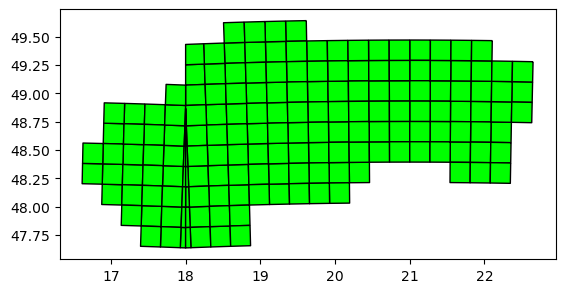

defaultdict(int,
            {'job_db persist': 1760,
             'track_statuses': 1588,
             'job_db get_by_status': 1558,
             'start_job call': 172,
             'job get status': 344,
             'job start': 172,
             'job launch': 172,
             'run_jobs loop': 1588,
             'sleep': 1588,
             'job describe': 9444,
             'job started running': 172,
             'job finished': 170,
             'job failed': 2})

In [24]:
# due to a bug in the JobManager class we first have to create the CSVJobDatabase by ourself and write it to disk so that we get all custom columns!
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(job_df)
    job_db.persist(df)

manager.run_jobs(start_job=point_extraction, job_db=job_db)

### combine the single results into one training data file
First load all the single parquet files of the jobs into `pandas.DataFrame` and combine.

In [25]:
# load the job_tracker file into a pandas DataFrame
df_tracker = pd.read_csv(job_tracker)

In [26]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
if all_finished:
    print("All jobs are finished.")
else:
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

All jobs are finished.


In [27]:
# print the costs of the full job
print(f'The feature extraction for {df_tracker.n_points.sum()} reference points has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')

The feature extraction for 45124 reference points has cost overall 7670 credits (76.7 EURO). 


In [28]:
# get the list of links to the job parquet files
df_tracker['path_result'] = df_tracker['file_prefix'].apply(lambda x: os.path.normpath(os.path.join(out_root, f'{x}.parquet')))
path_Results = df_tracker['path_result'].tolist()

In [29]:
# read parquet files and combine
combined_df = pd.concat([pd.read_parquet(p) for p in path_Results], ignore_index=True)

In [30]:
# get a list of extracted feature names
feature_names = [x for x in combined_df.columns.tolist() if x not in geo_df.columns.tolist()]
# remove some openEO generated columns
feature_names = [x for x in feature_names if x not in ["date", "feature_index"]]

In [33]:
# run a check before merging row of results == row of input
assert len(combined_df) == len(geo_df)

In [34]:
# merge in results
combined_df = combined_df.set_index('MGRSid10')
geo_df = geo_df.set_index('MGRSid10')
result_df = geo_df.join(combined_df[feature_names], how='left').reset_index()

In [35]:
result_df.head()

,MGRSid10,center_lon,center_lat,lon,lat,grid20id,valid_L1,valid_L2,valid_L3,label_L1,...,dist,occur,pop,bdod,cec,cfvo,clay,phh2o,sand,soc
0,33UXP57473908,17.118710,48.185468,17.118680,48.185489,33σXP21,True,True,True,C,...,6295.0,0.0,149.0,131.0,200.0,138.0,271.0,63.0,307.0,243.0
1,33UXP59864327,17.152421,48.222541,17.152425,48.222568,33σXP22,True,True,True,C,...,9223.0,0.0,407.0,132.0,210.0,136.0,254.0,62.0,325.0,222.0
2,33UXP63034439,17.195500,48.231803,17.195542,48.231791,33σXP32,True,True,True,C,...,9172.0,0.0,65.0,136.0,186.0,103.0,255.0,66.0,278.0,192.0
3,33UXP62884673,17.194382,48.252879,17.194425,48.252869,33σXP32,True,True,True,C,...,11402.0,0.0,74.0,133.0,172.0,167.0,236.0,60.0,298.0,204.0
4,33UXP63564713,17.203691,48.256300,17.203641,48.256284,33σXP32,True,True,True,C,...,11769.0,0.0,606.0,133.0,200.0,148.0,259.0,63.0,301.0,209.0


In [36]:
# save to disk as GeoPackage
file_name = os.path.basename(path_td).replace('.csv', '_Features_alpha1.gpkg')
path_gpkg = os.path.normpath(os.path.join(out_root, file_name))
result_df.to_file(path_gpkg, driver='GPKG')